In [1]:
# pip install --ignore-installed --no-cache-dir astro-datalab
import h5py
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import pandas as pd
from astropy import units as u
from astropy.coordinates import SkyCoord, ICRS, Galactic
from astroquery.xmatch import XMatch
from astroquery.gaia import Gaia
from astropy.table import Table, join,vstack
import healpy as hp
from astropy.io import fits
# %matplotlib inline
# from IPython.core.display import display, HTML

Could not import regions, which is required for some of the functionalities of this module.


<frozen importlib._bootstrap>:228: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject


## Check Lewis electron density map

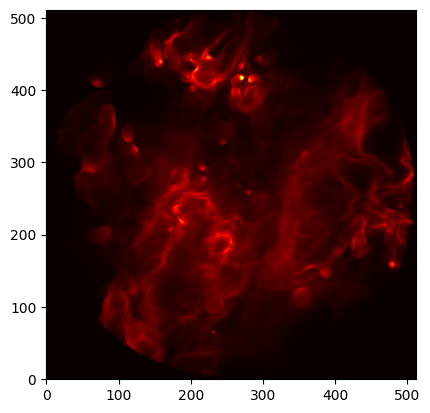

In [208]:
filename = '/Users/anniegao/Documents/CG_mapping_files/ne.hdf5'
with h5py.File(filename, "r") as f:
    density_grid = np.array(f['ne_cgs.hdf5'])
density_grid_transposed = np.transpose(density_grid,axes=(1,0,2))
plt.imshow(np.nansum(density_grid_transposed,axis=2),origin='lower',cmap='hot')

In [209]:
hdu = fits.PrimaryHDU(density_grid)
hdr = hdu.header
hdr['NAXIS'] = 3 #number of array dimensions
hdr['NAXIS1'] = 512
hdr['NAXIS2'] = 512
hdr['NAXIS3'] = 512
hdr['CTYPE1'] = 'Z' 
hdr['CUNIT1'] = 'pc'
hdr['CDELT1'] = 2500/512
hdr['CRVAL1'] = -1250
hdr['CRPIX1'] = 1.0
hdr['CTYPE2'] = 'Y' 
hdr['CUNIT2'] = 'pc'
hdr['CDELT2'] = 2500/512
hdr['CRVAL2'] = -1250
hdr['CRPIX2'] = 1.0
hdr['CTYPE3'] = 'X' 
hdr['CUNIT3'] = 'pc'
hdr['CDELT3'] = 2500/512
hdr['CRVAL3'] = -1250
hdr['CRPIX3'] = 1.0
hdr['CUNIT'] = 'erg s-1 cm-2 arcsec-2'
hdul = fits.HDUList([hdu])
# hdul.writeto('/Users/anniegao/Documents/CG_mapping_files/ne.fits')

In [210]:
f_ne = fits.open('/Users/anniegao/Documents/CG_mapping_files/ne.fits')[0]
f_ne.header

SIMPLE  =                    T / conforms to FITS standard                      
BITPIX  =                  -64 / array data type                                
NAXIS   =                    3 / number of array dimensions                     
NAXIS1  =                  512                                                  
NAXIS2  =                  512                                                  
NAXIS3  =                  512                                                  
EXTEND  =                    T                                                  
CTYPE1  = 'Z       '                                                            
CUNIT1  = 'pc      '                                                            
CDELT1  =            4.8828125                                                  
CRVAL1  =                -1250                                                  
CRPIX1  =                  1.0                                                  
CTYPE2  = 'Y       '        

### Cut the map around the Gum region

In [211]:
gum_ne = density_grid[188: 304, 114:230, 196:312]

In [212]:
hdu = fits.PrimaryHDU(gum_ne)
hdr = f_ne.header
hdr['NAXIS1'] = hdr['NAXIS2'] = hdr['NAXIS3'] = 116
hdr['CRVAL1'] = -1250 + 196*(2500/512)
hdr['CRVAL2'] = -1250 + 114*(2500/512)
hdr['CRVAL3'] = -1250 + 188*(2500/512)
hdu = fits.PrimaryHDU(gum_ne, header=hdr)
hdul = fits.HDUList([hdu])
# hdul.writeto('/Users/anniegao/Documents/CG_mapping_files/ne_Gum.fits')

### Check CGs in the electron map

In [213]:
CG_loc = pd.read_csv('/Users/anniegao/Documents/dustmaps_files/CG_w_tails.csv')

In [214]:
for CG in CG_loc.Name:
    t = Table(names=('x[px]', 'y[px]', 'z[pc]', 'l[deg]', 'b[deg]', 'd[pc]'))
    ra, dec = CG_loc[CG_loc['Name'] == CG]['ra_deg'], CG_loc[CG_loc['Name'] == CG]['dec_deg']
    for dis in range(250, 550, 10):
        coord0 = SkyCoord(SkyCoord(ra=ra, dec=dec, unit=(u.deg, u.deg),frame='icrs').transform_to(Galactic), distance = dis*u.pc)
        l = coord0.l.value[0]
        b = coord0.b.value[0]
        d = coord0.distance.value[0]
        x = coord0.cartesian.x.value[0]
        y =coord0.cartesian.y.value[0]
        z = coord0.cartesian.z.value[0]
        t.add_row([x, y, z, l, b, d])
    # t.write(f'/Users/anniegao/Documents/CG_mapping_files/CG_rays/{CG}_line.fits', overwrite = True)

In [215]:
## Check Yifei map
gum_1 = fits.open('/Users/anniegao/Dropbox/Gum_Nebula/data/gum_dust_map.fits')
Halpha_map = fits.open('/Users/anniegao/Downloads/Halpha.fits')
Halpha_map[0].header = gum_1[0].header
Halpha_map[0].header['NAXIS1'] = 75
Halpha_map[0].header['NAXIS2'] = 75
Halpha_map[0].header['NAXIS3'] = 75
# Halpha_map[0].header['CTYPE1'] = 'Z'
# Halpha_map[0].header['CTYPE3'] = 'X'
Halpha_map[0].header['CDELT1'] = 4.0
Halpha_map[0].header['CDELT2'] = 4.0
Halpha_map[0].header['CDELT3'] = 4.0
Halpha_map[0].header['CRVAL1'] = -180 
Halpha_map[0].header['CRVAL2'] = -480
Halpha_map[0].header['CRVAL3'] = -235
# Halpha_map.writeto('/Users/anniegao/Downloads/Halpha_headerCorrected.fits')

## Query stars

In [216]:
cg_table = pd.read_csv('/Users/anniegao/Documents/dustmaps_files/CG_w_tails.csv')
from astropy.table import Table
t = Table.read("/Users/anniegao/Documents/dustmaps_files/CG30_assoc_stars/CG30_stars.csv",format='csv')
t.colnames
t.remove_column('col0')
# t.write("CG30_Sep23.csv",format='csv')

FileNotFoundError: [Errno 2] No such file or directory: '/Users/anniegao/Documents/dustmaps_files/CG30_assoc_stars/CG30_stars.csv'

In [ ]:
print(qc.schema('decaps_dr2.x1p5__object__gaia_dr3__gaia_source'))


Schema: decaps_dr2
 Table: x1p5__object__gaia_dr3__gaia_source

     Column Name   Description
     -----------   -----------
             id1   ID in left/first table (obj_id)
             ra1   Right ascension in left/first table (ra)
            dec1   Declination in left/first table (dec)
             id2   ID in right/second table (source_id)
             ra2   Right ascension in right/second table (ra)
            dec2   Declination in right/second table (dec)
        distance   Distance between ra1,dec1 and ra2,dec2 (arcsec)



### Check the VVVX map

In [ ]:
vvvx_file = fits.open('/Users/anniegao/Documents/CG_mapping_files/CG31/jhk1017.fits')
vvvx = vvvx_file[1].data #mag_1 = J, mag_2 = H, mag_3 = Ks
vvvx_file[1].header

XTENSION= 'BINTABLE'           / binary table extension                         
BITPIX  =                    8 / array data type                                
NAXIS   =                    2 / number of array dimensions                     
NAXIS1  =                   64 / length of dimension 1                          
NAXIS2  =               319831 / length of dimension 2                          
PCOUNT  =                    0 / number of group parameters                     
GCOUNT  =                    1 / number of groups                               
TFIELDS =                    8 / number of table fields                         
TTYPE1  = 'ra      '                                                            
TFORM1  = 'D       '                                                            
TTYPE2  = 'dec     '                                                            
TFORM2  = 'D       '                                                            
TTYPE3  = 'mag_1   '        

## Entire CG 30-31 Complex

* Column information: https://datalab.noirlab.edu/query.php?name=decaps_dr2.object

In [ ]:
from astropy.io import fits
from astropy.wcs import WCS
f_CGplot = fits.open('/Users/anniegao/Documents/dustmaps_files/CG30_assoc_stars/CG30cutout_122.3822_-36.0713.fits')
CG_w = WCS(f_CGplot[0].header)

## Meeting Notes:
* Query CG 30-31 region; apply the 'chi square' mask to see the ones that fit well. 
* Look for ~3-4 mag of extinction jump.
* Add VVVX data later if needed
* build pipline
* Two mass column description:
https://irsa.ipac.caltech.edu/data/2MASS/docs/releases/allsky/doc/sec2_2a.html
<!-- * Make the plot in Demo 3 (uses 'dist_vs_red' function. adjust avlim values. ) -->

In [ ]:
# this version uses vizier, but we can use noirlab, as other catalog
# from astroquery.vizier import Vizier
# from astropy.coordinates import Angle
# import astropy.units as u
# import astropy.coordinates as coord
# vizier.ROW_LIMIT = -1
# ll = SkyCoord(ra = 122.46*u.deg, dec=-36.13*u.deg ) #lower left boundary
# print(ll.ra, ll.dec)
# ur = SkyCoord(ra = 122.30*u.deg, dec=-35.82*u.deg ) # upper right boundary
# print(ur.ra, ur.dec)
# vizier = Vizier()
# CG30_2mass = vizier.query_region(coord.SkyCoord(ra=122.38, dec=-35.975,
#                                                 unit=(u.deg, u.deg),frame='icrs'),
#                                                 width='0d9m36s',height = '0d18m36s',
#                                                 catalog = 'II/246/out') #II/241/out, II/246/out
# print(result)

In [ ]:
# To check duplicated rows:
# duplicates = merge_xmatch[merge_xmatch.duplicated(subset='obj_id', keep=False)]
# grouped_duplicates = duplicates.groupby('obj_id')
# for obj_id, group in grouped_duplicates:
#     print(f"Duplicated obj_id: {obj_id}")
#     print(group['angDist'])
#     print("Decide whether to keep the first or second occurrence.\n")

Notes: 

- CG30: \
        RA = (122.3, 122.46), Dec = (-36.13, -35.82)
- CG31: \
        RA = (122, 122.3), Dec = (-36.07, -35.83)
- CG31_back_reddened:  \
        RA = (121.7, 122.38), Dec = (-35.83, -35.6)

In [2]:
from dl import queryClient as qc
ra_bound1, ra_bound2 = 122.3, 122.46 #121.7, 122.38
dec_bound1, dec_bound2 = -36.13, -35.82 #-35.83, -35.6
region_name = "CG30" #"CG31_back_reddened"

In [ ]:
## query data
query1 = f"""
        SELECT *
        FROM decaps_dr2.object
        WHERE (ra<{ra_bound2} AND ra>{ra_bound1} AND dec<{dec_bound2} AND dec>{dec_bound1}) """
query3 = f"""SELECT * 
            FROM twomass.psc
            WHERE (ra<{ra_bound2} AND ra>{ra_bound1} AND dec<{dec_bound2} AND dec>{dec_bound1}) """
df1 = qc.query(sql=query1,fmt='table') # df1.write("/Users/anniegao/Documents/CG_mapping_files/CG31/CG31_decaps2.csv", format='csv')
df3 = qc.query(sql=query3,fmt='table') # df3.write("/Users/anniegao/Documents/CG_mapping_files/CG31/CG31_2mass.csv", format='csv')

## Cross Match with Gaia
from astroquery.xmatch import XMatch
gaia_xmatched = XMatch.query(cat1 = df1, cat2='vizier:I/355/gaiadr3', max_distance= 0.5*u.arcsec, colRA1='ra', colDec1='dec')
df1_pd = df1.to_pandas()
xmatch_pd = gaia_xmatched.to_pandas()
xmatch_pd_tomerge = xmatch_pd.iloc[:, 210:]
xmatch_pd_tomerge['obj_id'] = xmatch_pd['obj_id'].values
xmatch_pd_tomerge['angDist'] = xmatch_pd['angDist'].values
merge_xmatch = df1_pd.merge(xmatch_pd_tomerge, how='left', left_on='obj_id', right_on='obj_id')
merged_pd = merge_xmatch.drop_duplicates(subset='obj_id', keep='first') # because there are 13 stars that are duplicated -- two Gaia sources are within 0.5 arcsec from Decaps2. Only keep the closer one. 
merged_table = Table.from_pandas(merged_pd) # convert back to astropy table # merged_table.write("/Users/anniegao/Documents/CG_mapping_files/CG31/CG31_Decaps2Gaia_crossmatched.csv",format='csv')
print('Finished crossmatching with Gaia')
## Cross Match with 2MASS
twomass_xmatched = XMatch.query(cat1 = df1, cat2 = 'vizier:II/246/out', max_distance= 0.5*u.arcsec, colRA1='ra', colDec1='dec')
twomass_xmatch_pd = twomass_xmatched.to_pandas()
twomass_xmatch_id = twomass_xmatch_pd.iloc[:, 210:211]
twomass_xmatch_id['obj_id'] = twomass_xmatch_pd['obj_id'].values
twomass_xmatch_id['angDist'] = twomass_xmatch_pd['angDist'].values
merge1 = df1_pd.merge(twomass_xmatch_id, how='left', left_on='obj_id', right_on='obj_id')
merge2 = merge1.merge(df3.to_pandas().iloc[:, 2:], how='left',left_on='2MASS', right_on = 'designation') # Table.from_pandas(merge2).write("/Users/anniegao/Documents/CG_mapping_files/CG31/CG31_Decaps2TwoMASS_crossmatched.csv",format='csv', overwrite=True)
print('Finished crossmatching with 2MASS')
## Merge three tables
a = merge2.iloc[:, 209:]
a['obj_id'] = merge2['obj_id']
decaps_2mass_gaia = merged_table.to_pandas().merge(a, on = 'obj_id') # merge Decaps + 2MASS with Decaps + Gaia 
print('Finished crossmatching Decaps2, Gaia, 2MASS; and saved.')
# Table.from_pandas(decaps_2mass_gaia).write(f"/Users/anniegao/Documents/CG_mapping_files/CG31/{region_name}_Decaps2TwoMASS_Gaia_crossmatched.csv",format='csv', overwrite=True)

Finished crossmatching with Gaia
Finished crossmatching with 2MASS
Finished crossmatching Decaps2, Gaia, 2MASS; and saved.


In [ ]:
## confirm the stars are covering the globule and not other background region
# merge CG30, CG31, CG31-backreddened region data
# table1 = pd.read_csv('/Users/anniegao/Documents/CG_mapping_files/CG30/CG30_Decaps2TwoMASS_Gaia_crossmatched.csv')
# table2 = pd.read_csv('/Users/anniegao/Documents/CG_mapping_files/CG31/CG31_Decaps2TwoMASS_Gaia_crossmatched.csv')
# table3 = pd.read_csv('/Users/anniegao/Documents/CG_mapping_files/CG31/CG31_back_reddened_Decaps2TwoMASS_Gaia_crossmatched.csv')
# pd.concat([table1, table2, table3]).to_csv('/Users/anniegao/Documents/CG_mapping_files/CG31/CG30_CG31_CG31back_decaps2MassGaia_crossmatched.csv', index=False)

### Brutus for stellar modeling

In [3]:
import os
import brutus
import h5py
import sys
import glob
from brutus import filters
from brutus import seds
from brutus import utils
from brutus.utils import inv_magnitude
from brutus import fitting
from brutus import pdf
from scipy import stats
from numpy import unravel_index
import signal
import time
from zero_point import zpt
import shutil

In [ ]:
merged_table2 = Table.read('/Users/anniegao/Documents/CG_mapping_files/CG31/CG31_Decaps2TwoMASS_Gaia_crossmatched.csv',format='csv')
merged_table3 = Table.read('/Users/anniegao/Documents/dustmaps_files/CG30_assoc_stars/CG30region_Decaps2TwoMASS_Gaia_crossmatched.csv',format='csv')
band_check2 = np.c_[(merged_table2['nmag_cflux_ok_g']>0) & (merged_table2['mean_mag_g']< np.inf) & (merged_table2['fracflux_avg_g']>0.75),
                   (merged_table2['nmag_cflux_ok_r']>0) & (merged_table2['mean_mag_r']< np.inf) & (merged_table2['fracflux_avg_r']>0.75),
                   (merged_table2['nmag_cflux_ok_i']>0) & (merged_table2['mean_mag_i']< np.inf) & (merged_table2['fracflux_avg_i']>0.75),
                   (merged_table2['nmag_cflux_ok_z']>0) & (merged_table2['mean_mag_z']< np.inf) & (merged_table2['fracflux_avg_z']>0.75), 
                   (merged_table2['nmag_cflux_ok_y']>0) & (merged_table2['mean_mag_y']< np.inf) & (merged_table2['fracflux_avg_y']>0.75), 
                   (merged_table2['j_m']>0) & (merged_table2['cc_flg']==0) & (merged_table2['gal_contam'] ==0), 
                   (merged_table2['h_m']>0) & (merged_table2['cc_flg']==0) & (merged_table2['gal_contam'] ==0), 
                   (merged_table2['k_m']>0) & (merged_table2['cc_flg']==0) & (merged_table2['gal_contam'] ==0)
                   ]
band_mask2 = np.sum(band_check2, axis=1)>=4
merged_table_selected2 = merged_table2[band_mask2]
flux2 = np.c_[merged_table_selected2['mean_g'], merged_table_selected2['mean_r'], merged_table_selected2['mean_i'], merged_table_selected2['mean_z'], merged_table_selected2['mean_y'],
             merged_table_selected2['j_m'].value, merged_table_selected2['h_m'].value, merged_table_selected2['k_m'].value ] #merged_table['Gmag'], merged_table['BPmag'], merged_table['RPmag'],
flux_err2 = np.c_[merged_table_selected2['err_g'], merged_table_selected2['err_r'], merged_table_selected2['err_i'],merged_table_selected2['err_z'], merged_table_selected2['err_y'],
                 merged_table_selected2['j_msigcom'].value, merged_table_selected2['h_msigcom'].value, merged_table_selected2['k_msigcom'].value]  #merged_table['e_Gmag'], merged_table['e_BPmag'], merged_table['e_RPmag'],
flux_not_close02 = ~np.isclose(flux2, 0.)
flux_mask2 = np.sum(flux_not_close02, axis=1)>=4
flux_new2 = flux2[flux_mask2, :]
flux_err_new2 = flux_err2[flux_mask2, :]
mask2 = np.isfinite(flux_err_new2)  # create boolean band mask
parallax2, parallax_err2 = merged_table_selected2['Plx'], merged_table_selected2['e_Plx']
parallax2 = parallax2[flux_mask2]
parallax_err2 = parallax_err2[flux_mask2]
psel2 = np.isclose(parallax_err2, 0.) | np.isclose(parallax2, 0.) | (parallax_err2 > 1e6)
parallax2[psel2], parallax_err2[psel2] = np.nan, np.nan
coords2 = SkyCoord(ra = merged_table_selected2['ra'].value*u.deg, dec=merged_table_selected2['dec'].value*u.deg ).transform_to('galactic')
coords2 = coords2[flux_mask2]


band_check3 = np.c_[(merged_table3['nmag_cflux_ok_g']>0) & (merged_table3['mean_mag_g']< np.inf) & (merged_table3['fracflux_avg_g']>0.75),
                   (merged_table3['nmag_cflux_ok_r']>0) & (merged_table3['mean_mag_r']< np.inf) & (merged_table3['fracflux_avg_r']>0.75),
                   (merged_table3['nmag_cflux_ok_i']>0) & (merged_table3['mean_mag_i']< np.inf) & (merged_table3['fracflux_avg_i']>0.75),
                   (merged_table3['nmag_cflux_ok_z']>0) & (merged_table3['mean_mag_z']< np.inf) & (merged_table3['fracflux_avg_z']>0.75), 
                   (merged_table3['nmag_cflux_ok_y']>0) & (merged_table3['mean_mag_y']< np.inf) & (merged_table3['fracflux_avg_y']>0.75), 
                   (merged_table3['Jmag']>0) , 
                   (merged_table3['Hmag']>0) , 
                   (merged_table3['Kmag']>0)
                   ]
band_mask3 = np.sum(band_check3, axis=1)>=4
merged_table_selected3 = merged_table3[band_mask3]
flux3 = np.c_[merged_table_selected3['mean_g'], merged_table_selected3['mean_r'], merged_table_selected3['mean_i'], merged_table_selected3['mean_z'], merged_table_selected3['mean_y'],
             merged_table_selected3['Jmag'].value, merged_table_selected3['Hmag'].value, merged_table_selected3['Kmag'].value ] #merged_table['Gmag'], merged_table['BPmag'], merged_table['RPmag'],
flux_err3 = np.c_[merged_table_selected3['err_g'], merged_table_selected3['err_r'], merged_table_selected3['err_i'],merged_table_selected3['err_z'], merged_table_selected3['err_y'],
                 merged_table_selected3['e_Jmag'].value, merged_table_selected3['e_Hmag'].value, merged_table_selected3['e_Kmag'].value]  #merged_table['e_Gmag'], merged_table['e_BPmag'], merged_table['e_RPmag'],
flux_not_close03 = ~np.isclose(flux3, 0.)
flux_mask3 = np.sum(flux_not_close03, axis=1)>=4
flux_new3 = flux3[flux_mask3, :]
flux_err_new3 = flux_err3[flux_mask3, :]
mask3 = np.isfinite(flux_err_new3)  # create boolean band mask
parallax3, parallax_err3 = merged_table_selected3['Plx'], merged_table_selected3['e_Plx']
parallax3 = parallax3[flux_mask3]
parallax_err3 = parallax_err3[flux_mask3]
psel3 = np.isclose(parallax_err3, 0.) | np.isclose(parallax3, 0.) | (parallax_err3 > 1e6)
parallax3[psel3], parallax_err3[psel3] = np.nan, np.nan
coords3 = SkyCoord(ra = merged_table_selected3['ra'].value*u.deg, dec=merged_table_selected3['dec'].value*u.deg ).transform_to('galactic')
coords3 = coords3[flux_mask3]

In [4]:
## Fit data 
Ndraws = 100 #draws to save to generate the 2D posterior
thin = 20 # factor to thin samples by for saving to disk
filt = filters.decam[1:] + filters.tmass[:] + filters.vista[2:] #+filters.gaia[:]
# zero points
zp_mist = brutus.utils.load_offsets('/Users/anniegao/Documents/CG_mapping_files/star_modeling/offsets_mist_v9.txt',filters=filt)
# import MIST model grid
gridfile = '/Users/anniegao/Documents/CG_mapping_files/star_modeling/grid_mist_v10.h5'
(models_mist, labels_mist, lmask_mist) = brutus.utils.load_models(gridfile, filters=filt)
BF_mist = fitting.BruteForce(models_mist, labels_mist, lmask_mist)
#load tables for parallax zeropoint correction
zpt.load_tables()

DECam_g (0.0%)
DECam_r (-4.0%)
DECam_i (-5.0%)
DECam_z (-4.0%)
DECam_Y (-5.0%)
2MASS_J (-2.0%)
2MASS_H (4.0%)
2MASS_Ks (3.0%)
VISTA_J (-4.0%)
VISTA_H (3.0%)
VISTA_Ks (2.0%)
Reading filter DECam_g           

Reading filter VISTA_Ks           


In [42]:
merged_table_path = '/Users/anniegao/Documents/CG_mapping_files/CG31/CG31_selected.csv'  #f"/Users/anniegao/Documents/CG_mapping_files/CG31/{region_name}_Decaps2TwoMASS_Gaia_crossmatched.csv"

vvvx_Decaps_CG31 = pd.read_csv('/Users/anniegao/Documents/CG_mapping_files/CG31/vvvxDecaps_CG31.txt', sep=',')
vvvx_to_merge = vvvx_Decaps_CG31.iloc[:, :8].rename(columns={"t1_ra": "ra_vvvx", "t1_dec": 'dec_vvvx', 
                                                             "t1_mag_1": "J_vvvx", "t1_er_1": "err_J_vvvx",
                                                             "t1_mag_2": "H_vvvx", "t1_er_2": "err_H_vvvx",
                                                             "t1_mag_3": "Ks_vvvx", "t1_er_3": "err_Ks_vvvx"
                                                            })
vvvx_to_merge['obj_id'] = vvvx_Decaps_CG31['obj_id']
pd_merged = pd.read_csv(merged_table_path).join(vvvx_to_merge.set_index('obj_id'), on='obj_id')  #.merge(vvvx_to_merge, on = 'obj_id')

In [43]:
## distance: 200-600pc. aka 1000/600<plx<1000/200
dist_select = pd_merged[~((pd_merged['Plx']< 1000/600)|(pd_merged['Plx']>1000/200))]
merged_table = Table.from_pandas(dist_select)

In [44]:
## post-process the data, quality cut
band_check = np.c_[(merged_table['nmag_cflux_ok_g']>0) & (merged_table['mean_mag_g']< np.inf) & (merged_table['fracflux_avg_g']>0.75),
                   (merged_table['nmag_cflux_ok_r']>0) & (merged_table['mean_mag_r']< np.inf) & (merged_table['fracflux_avg_r']>0.75),
                   (merged_table['nmag_cflux_ok_i']>0) & (merged_table['mean_mag_i']< np.inf) & (merged_table['fracflux_avg_i']>0.75),
                   (merged_table['nmag_cflux_ok_z']>0) & (merged_table['mean_mag_z']< np.inf) & (merged_table['fracflux_avg_z']>0.75), 
                   (merged_table['nmag_cflux_ok_y']>0) & (merged_table['mean_mag_y']< np.inf) & (merged_table['fracflux_avg_y']>0.75), 
                   (merged_table['j_m']>0) & (merged_table['cc_flg'] =='000') & (merged_table['gal_contam'] ==0), 
                   (merged_table['h_m']>0) & (merged_table['cc_flg']=='000') & (merged_table['gal_contam'] ==0), 
                   (merged_table['k_m']>0) & (merged_table['cc_flg']=='000') & (merged_table['gal_contam'] ==0),
                   (merged_table['J_vvvx']>0) & (merged_table['err_J_vvvx']>0) , 
                   (merged_table['H_vvvx']>0) & (merged_table['err_H_vvvx']>0) , 
                   (merged_table['Ks_vvvx']>0) & (merged_table['err_Ks_vvvx']>0) , 
                   ]
band_mask = (np.sum(band_check, axis=1)>=4 ) & (np.sum(band_check[:, :5], axis=1)>=1)
merged_table_selected = merged_table[band_mask]

flux_decam = np.c_[merged_table_selected['mean_g'].value, merged_table_selected['mean_r'].value, merged_table_selected['mean_i'].value, merged_table_selected['mean_z'].value, merged_table_selected['mean_y'].value]
mag_2mass =  np.c_[merged_table_selected['j_m'].value, merged_table_selected['h_m'].value, merged_table_selected['k_m'].value ] #merged_table['Gmag'], merged_table['BPmag'], merged_table['RPmag'],
mag_vvvx = np.c_[merged_table_selected['J_vvvx'].value, merged_table_selected['H_vvvx'].value, merged_table_selected['Ks_vvvx'].value ]
flux_decam_err = np.c_[merged_table_selected['err_g'].value, merged_table_selected['err_r'].value, merged_table_selected['err_i'].value,merged_table_selected['err_z'].value, merged_table_selected['err_y'].value]
magerr_2mass = np.c_[merged_table_selected['j_msigcom'].value, merged_table_selected['h_msigcom'].value, merged_table_selected['k_msigcom'].value]  #merged_table['e_Gmag'], merged_table['e_BPmag'], merged_table['e_RPmag'],
magerr_vvvx = np.c_[merged_table_selected['err_J_vvvx'].value, merged_table_selected['err_H_vvvx'].value, merged_table_selected['err_Ks_vvvx'].value ]
#mag, mag_err = utils.magnitude(flux, flux_err)
mag_decam = -2.5*np.log10(flux_decam)
magerr_decam = 1.086*flux_decam_err/flux_decam
mag = np.c_[mag_decam[:], mag_2mass[:], mag_vvvx[:]]
mag_err = np.c_[magerr_decam[:], magerr_2mass[:], magerr_vvvx[:]]

#add 0.02 mag uncertainty in quadrature to decaps
mag_err[:,0:5] = np.sqrt(mag_err[:,0:5]**2 + 0.02**2)
#add 0.03 mag uncertainty in quadrature to vvv/2mass
mag_err[:,5:] = np.sqrt(mag_err[:,5:]**2 + 0.03**2)


/var/folders/dl/nphr1_sx2rz54lxlh_6ymdj00000gn/T/ipykernel_46154/2615525753.py:24: RuntimeWarning: divide by zero encountered in log10
  mag_decam = -2.5*np.log10(flux_decam)
/var/folders/dl/nphr1_sx2rz54lxlh_6ymdj00000gn/T/ipykernel_46154/2615525753.py:25: RuntimeWarning: invalid value encountered in divide
  magerr_decam = 1.086*flux_decam_err/flux_decam


In [ ]:
mag = np.where(np.isinf(mag), np.nan, mag)
mag_err = np.where(mag_err>0.25, np.nan, mag_err)
clean = np.isfinite(mag) & np.isfinite(mag_err) & (mag_err>0.)
mask_tri = (np.sum(clean, axis=1)>=4) & (np.sum(clean[:, :5], axis=1)>=1)


In [53]:
# convert back to flux
flux, flux_err = inv_magnitude(mag, mag_err)
parallax, parallax_err = merged_table_selected['Plx'], merged_table_selected['e_Plx']
correct_parallax_mask = (np.isfinite(parallax)) & (np.isin(merged_table_selected['Solved'], [31, 95]))
from zero_point import zpt
#apply parallax correction
parallax_correction = zpt.get_zpt(merged_table_selected['Gmag'][correct_parallax_mask], 
                                  merged_table_selected['nueff'][correct_parallax_mask], 
                                  merged_table_selected['pscol'][correct_parallax_mask], 
                                  merged_table_selected['elat'][correct_parallax_mask], 
                                  merged_table_selected['Solved'][correct_parallax_mask],
                                  _warnings=False)

parallax_correction[~np.isfinite(parallax_correction)] = 0 
parallax[correct_parallax_mask] = parallax[correct_parallax_mask]-parallax_correction

# psel = np.isclose(parallax_err, 0.) | np.isclose(parallax, 0.) | (parallax_err > 1e6)
# parallax[psel], parallax_err[psel] = np.nan, np.nan
coords = SkyCoord(ra = merged_table_selected['ra'].value*u.deg, dec = merged_table_selected['dec'].value*u.deg ).transform_to('galactic')


In [59]:
filename = '/Users/anniegao/Documents/CG_mapping_files/star_modeling/output/'
region_data = f'CG31_mist_from_decapsTwomassGaiaVVVX_trial2'
BF_mist.fit(flux[::30], flux_err[::30], np.tile(mask_tri[:, np.newaxis], (1, 11))[::30], 
            merged_table_selected['SolID'][::30], 
            filename+region_data,
            data_coords = np.c_[coords.l.value, coords.b.value][::30], 
            merr_max = 0.5,
            parallax=parallax[::30], 
            parallax_err=parallax_err[::30],
            phot_offsets = zp_mist, 
            # dustfile = dustfile, 
            Ndraws = 250, 
            Nmc_prior = 50, 
            logl_dim_prior=True,
            save_dar_draws = True, 
            running_io = True, 
            verbose= True
            )

Fitting object 259/259 [chi2/n: 3.1/7] (mean time: 1.218 s/obj, est. time remaining:      0.000 s)    


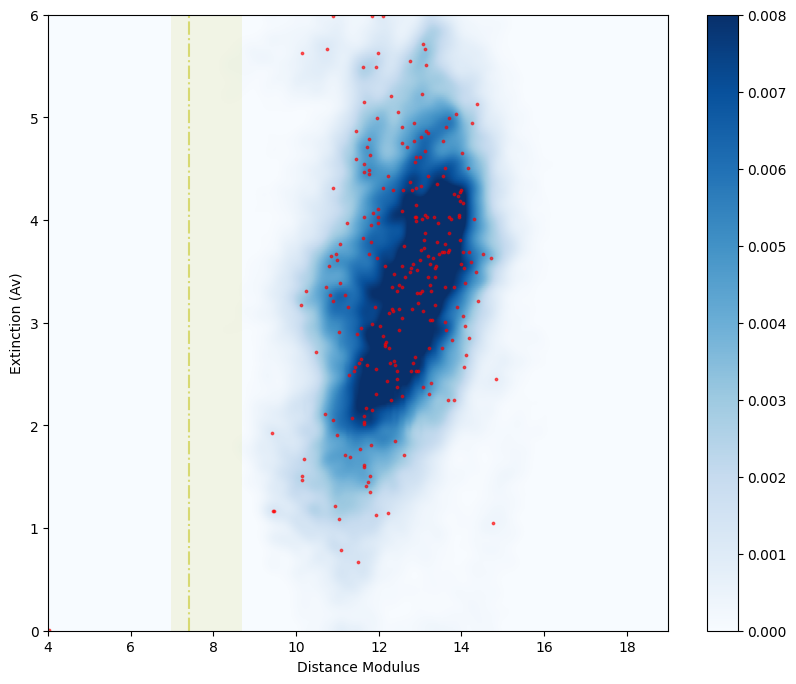

In [60]:
f = h5py.File(filename+region_data+'.h5', 'r')
idxs_mist = f['model_idx']  #model indices
chi2_mist =f['obj_chi2min'] #best fit chi2
nbands_mist = f['obj_Nbands']# number of bands in fit
dists_mist = f['samps_dist'] # distance samples
reds_mist = f['samps_red'] # A(V) samples
dreds_mist = f['samps_dred']# R(V) samples
lnps_mist = f['samps_logp']# log-posterior of samples
good=(stats.chi2.sf(chi2_mist, nbands_mist) > 0.01)
pval = stats.chi2.sf(chi2_mist, nbands_mist)
dists_mist = np.array(dists_mist)
reds_mist = np.array(reds_mist)
dreds_mist = np.array(dreds_mist)
import warnings
warnings.filterwarnings("ignore")
pdfbin, xedges, yedges = brutus.pdf.bin_pdfs_distred((dists_mist, reds_mist, dreds_mist), 
                                                     parallaxes = parallax.value,  # limits smoothing
                                                     parallax_errors=parallax_err.value,  # if parallax SNR is high
                                                    #  avlim=(0., 4.5),
                                                     )
pdfbin = pdfbin[good, :, :]
# plt.imshow(pdfbin[0,:,:])
fig, ax = plt.subplots(figsize=(10, 8))# Prepare the plot
# Set axis labels
ax.set_xlabel('Distance Modulus')
ax.set_ylabel('Extinction (Av)')

# find the location of max likelihood for each star. 
# Step 1: Compute the indices of the maxima
N_stars = pdfbin.shape[0]
max_positions = np.argmax(pdfbin.reshape(N_stars, -1), axis=1)
x_idx, y_idx = np.unravel_index(max_positions, (750, 300))  # shape: (N_stars,)

# Step 2: Convert bin indices to physical coordinates (use center of bins)
x_centers = 0.5 * (xedges[:-1] + xedges[1:])  # shape: (750,)
y_centers = 0.5 * (yedges[:-1] + yedges[1:])  # shape: (300,)

x_max = x_centers[x_idx]
y_max = y_centers[y_idx]

plt.scatter(x_max, y_max, color='red', s=3, alpha=0.6, label='Star max PDF location')

#  sum: collapses the first dimension — aggregating multiple PDFs
plt.imshow(np.sum(pdfbin, axis=0).T, aspect='auto', cmap='Blues', interpolation=None, origin='lower', 
            extent=[xedges[0], xedges[-1], yedges[0], yedges[-1]],
            vmin=0, vmax=0.008
            )
# plt.xlim(4, 10)
plt.axvline(7.4, c='y', alpha=0.5, ls='-.')
plt.axvspan(6.98, 8.7, facecolor='y', alpha=0.1)
plt.colorbar()
plt.show()

In [140]:
print(len(coords)) # with vvvx added
# merged_table_selected[flux_mask].write(f"/Users/anniegao/Documents/CG_mapping_files/CG31/CG31_fitting_withVVVX.csv",format='csv', overwrite=True)

2422


In [9]:
print(len(coords))
# merged_table_selected[flux_mask].write(f"/Users/anniegao/Documents/CG_mapping_files/CG31/CG30-CG31_CG31back_fitting.csv",format='csv', overwrite=True)

2255


In [ ]:
dustfile = '/Users/anniegao/Dropbox/Gum_Nebula/data/gum_dust_map.fits'  # 3-D dust map
filename = '/Users/anniegao/Documents/CG_mapping_files/star_modeling/output/'
region_data = f'CG31_mist_from_decapsTwomassGaiaVVVX'
BF_mist.fit(flux_new[::3], flux_err_new[::3], mask[::3], 
            merged_table_selected['SolID'][::3], 
            filename+region_data,
            data_coords = np.c_[coords.l.value, coords.b.value][::3], 
            parallax=parallax[::3], 
            parallax_err=parallax_err[::3],
            phot_offsets = zp_mist, 
            # dustfile = dustfile, 
            Ndraws = 250, 
            Nmc_prior = 50, 
            logl_dim_prior=True,
            save_dar_draws = True, 
            running_io = True, 
            verbose= True
            )

Fitting object 808/808 [chi2/n: 10.4/8] (mean time: 1.206 s/obj, est. time remaining:      0.000 s)    


### Load Results

The result of stats.chi2.sf(chi2_mist, nbands_mist) is a p-value, defined as: \
$p = P(\chi^2 >= \chi_{mist} |H0)$

$p$ small: reject the model \
$p$ large: the model is a plausible fit

Here $p$ is 1% significance level. \

chi2_mist is not the raw data or the model prediction; it is precomputed chi-squared test statistic. Now we use the stat.chi2.sf to compute the p-value from this statistic.

In [99]:
f = h5py.File(filename+region_data+'.h5', 'r')
idxs_mist = f['model_idx']  #model indices
chi2_mist =f['obj_chi2min'] #best fit chi2
nbands_mist = f['obj_Nbands']# number of bands in fit
dists_mist = f['samps_dist'] # distance samples
reds_mist = f['samps_red'] # A(V) samples
dreds_mist = f['samps_dred']# R(V) samples
lnps_mist = f['samps_logp']# log-posterior of samples
good=(stats.chi2.sf(chi2_mist, nbands_mist) > 0.01)
pval = stats.chi2.sf(chi2_mist, nbands_mist)
# plt.hist(chi2_mist[good],bins=np.linspace(0,100),alpha=0.5)
# plt.hist(chi2_mist[~good],bins=np.linspace(0,100),alpha=0.5)

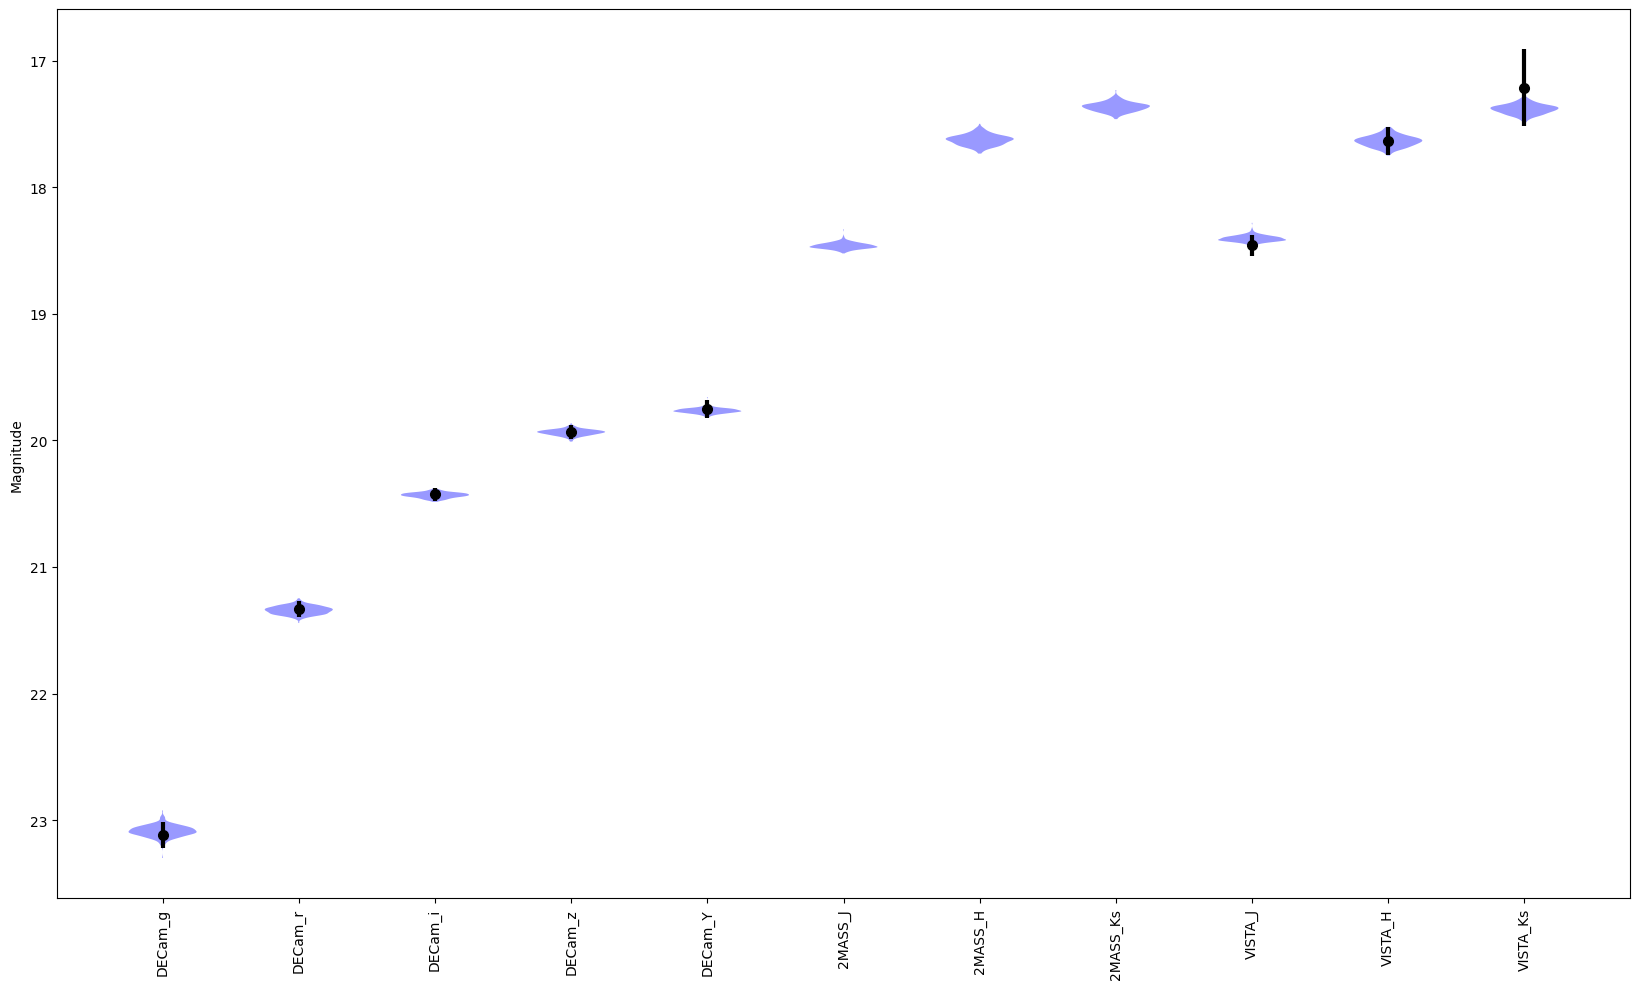

In [100]:
# pick an object
i = 0
from brutus import plotting as bplot
# plot SED (posterior predictive)
fig, ax, parts = bplot.posterior_predictive(models_mist,  # stellar model grid
                                            idxs_mist[i],  # model indices
                                            reds_mist[i],  # A(V) draws
                                            dreds_mist[i],  # R(V) draws
                                            dists_mist[i],  # distance draws
                                            data=flux_new[i], data_err=flux_err_new[i],  # data
                                            # flux = True,
                                            data_mask=mask[i],  # band mask
                                            offset=zp_mist,  # photometric offsets
                                            psig=2.,  # plot 2-sigma errors
                                            labels=filt,  # filters 
                                            vcolor='blue',  # "violin plot" colors for the posteriors
                                            pcolor='black')  # photometry colors for the data

In [101]:
dists_mist = np.array(dists_mist)
reds_mist = np.array(reds_mist)
dreds_mist = np.array(dreds_mist)

In [102]:
import warnings
warnings.filterwarnings("ignore")
pdfbin, xedges, yedges = brutus.pdf.bin_pdfs_distred((dists_mist, reds_mist, dreds_mist), 
                                                     parallaxes = parallax.value,  # limits smoothing
                                                     parallax_errors=parallax_err.value,  # if parallax SNR is high
                                                    #  avlim=(0., 4.5),
                                                     )
pdfbin = pdfbin[good, :, :]

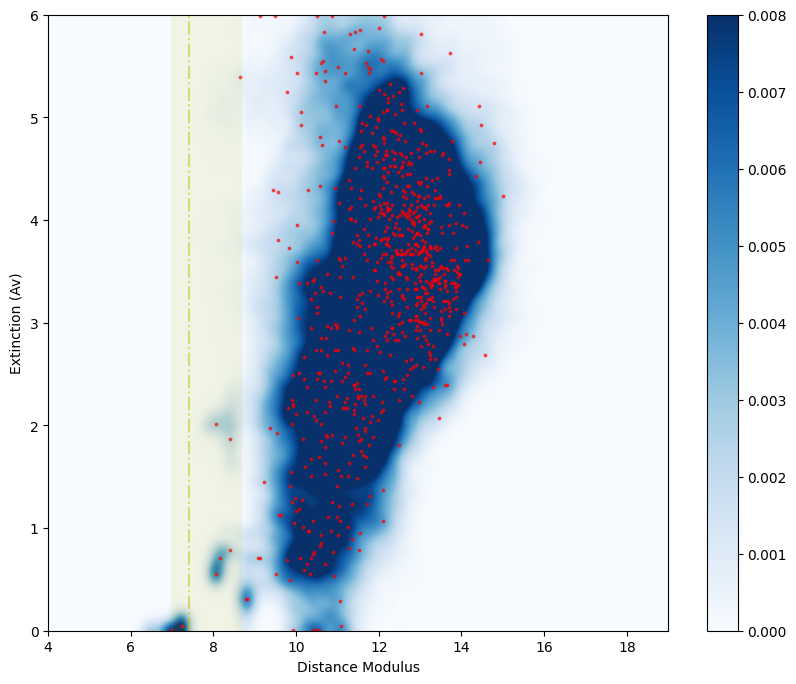

In [ ]:
# plt.imshow(pdfbin[0,:,:])
fig, ax = plt.subplots(figsize=(10, 8))# Prepare the plot
# Set axis labels
ax.set_xlabel('Distance Modulus')
ax.set_ylabel('Extinction (Av)')

# find the location of max likelihood for each star. 
# Step 1: Compute the indices of the maxima
N_stars = pdfbin.shape[0]
max_positions = np.argmax(pdfbin.reshape(N_stars, -1), axis=1)
x_idx, y_idx = np.unravel_index(max_positions, (750, 300))  # shape: (N_stars,)

# Step 2: Convert bin indices to physical coordinates (use center of bins)
x_centers = 0.5 * (xedges[:-1] + xedges[1:])  # shape: (750,)
y_centers = 0.5 * (yedges[:-1] + yedges[1:])  # shape: (300,)

x_max = x_centers[x_idx]
y_max = y_centers[y_idx]

plt.scatter(x_max, y_max, color='red', s=3, alpha=0.6, label='Star max PDF location')

#  sum: collapses the first dimension — aggregating multiple PDFs
plt.imshow(np.sum(pdfbin, axis=0).T, aspect='auto', cmap='Blues', interpolation=None, origin='lower', 
            extent=[xedges[0], xedges[-1], yedges[0], yedges[-1]],
            vmin=0, vmax=0.008
            )
# plt.xlim(4, 10)
plt.axvline(7.4, c='y', alpha=0.5, ls='-.')
plt.axvspan(6.98, 8.7, facecolor='y', alpha=0.1)
plt.colorbar()
plt.show()

In [125]:
region_data

'CG31_mist_from_decapsTwomassGaiaVVVX'

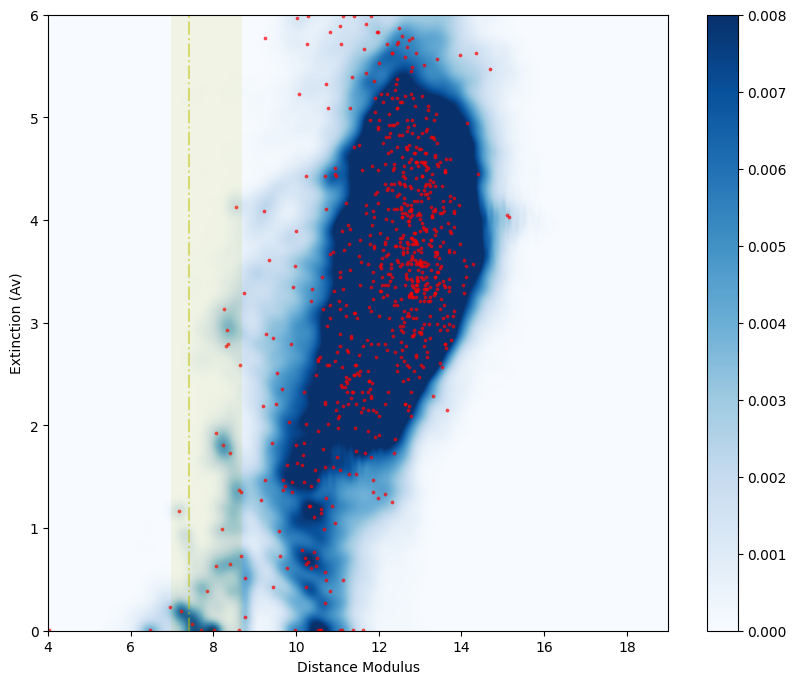

In [126]:
## without vvvx:
region_data2 = 'CG31_mist_from_decapsTwomassGaia'
f = h5py.File(filename+region_data2+'.h5', 'r')
idxs_mist = f['model_idx']  #model indices
chi2_mist =f['obj_chi2min'] #best fit chi2
nbands_mist = f['obj_Nbands']# number of bands in fit
dists_mist = f['samps_dist'] # distance samples
reds_mist = f['samps_red'] # A(V) samples
dreds_mist = f['samps_dred']# R(V) samples
lnps_mist = f['samps_logp']# log-posterior of samples
good=(stats.chi2.sf(chi2_mist, nbands_mist) > 0.01)
pval = stats.chi2.sf(chi2_mist, nbands_mist)
dists_mist = np.array(dists_mist)
reds_mist = np.array(reds_mist)
dreds_mist = np.array(dreds_mist)
warnings.filterwarnings("ignore")
pdfbin, xedges, yedges = brutus.pdf.bin_pdfs_distred((dists_mist, reds_mist, dreds_mist), 
                                                     parallaxes = parallax.value,  # limits smoothing
                                                     parallax_errors=parallax_err.value,  # if parallax SNR is high
                                                    #  avlim=(0., 4.5),
                                                     )
pdfbin = pdfbin[good, :, :]
fig, ax = plt.subplots(figsize=(10, 8))# Prepare the plot
# Set axis labels
ax.set_xlabel('Distance Modulus')
ax.set_ylabel('Extinction (Av)')

# find the location of max likelihood for each star. 
# Step 1: Compute the indices of the maxima
N_stars = pdfbin.shape[0]
max_positions = np.argmax(pdfbin.reshape(N_stars, -1), axis=1)
x_idx, y_idx = np.unravel_index(max_positions, (750, 300))  # shape: (N_stars,)

# Step 2: Convert bin indices to physical coordinates (use center of bins)
x_centers = 0.5 * (xedges[:-1] + xedges[1:])  # shape: (750,)
y_centers = 0.5 * (yedges[:-1] + yedges[1:])  # shape: (300,)

x_max = x_centers[x_idx]
y_max = y_centers[y_idx]

plt.scatter(x_max, y_max, color='red', s=3, alpha=0.6, label='Star max PDF location')

#  sum: collapses the first dimension — aggregating multiple PDFs
plt.imshow(np.sum(pdfbin, axis=0).T, aspect='auto', cmap='Blues', interpolation=None, origin='lower', 
            extent=[xedges[0], xedges[-1], yedges[0], yedges[-1]],
            vmin=0, vmax=0.008
            )
# plt.xlim(4, 10)
plt.axvline(7.4, c='y', alpha=0.5, ls='-.')
plt.axvspan(6.98, 8.7, facecolor='y', alpha=0.1)
plt.colorbar()
plt.show()

409


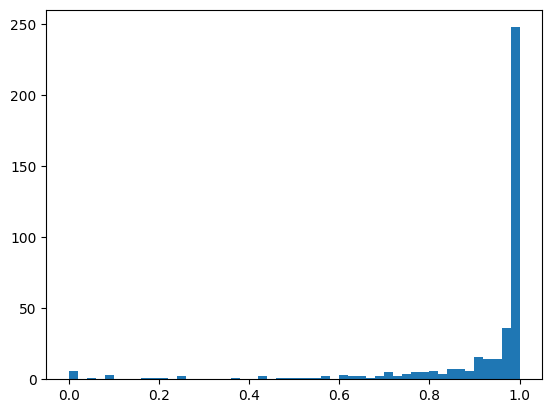

In [ ]:
# print(sum(good))
# plt.hist(pval, bins=50)
# plt.show()

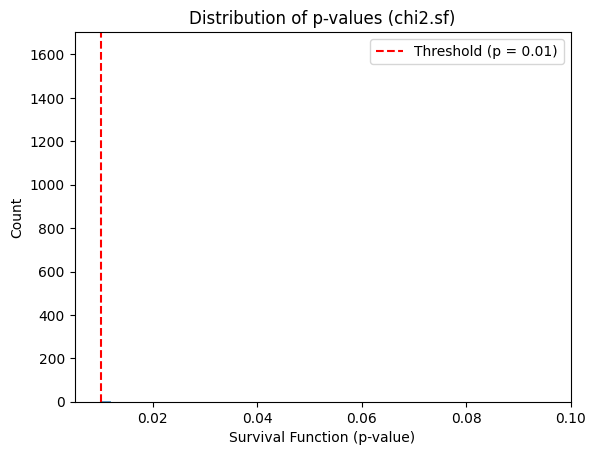

In [34]:
p_values = stats.chi2.sf(chi2_mist, df=nbands_mist)

plt.hist(p_values, bins=500, alpha=0.7)
plt.axvline(0.01, color='red', linestyle='--', label='Threshold (p = 0.01)')
plt.xlabel('Survival Function (p-value)')
plt.ylabel('Count')
plt.title('Distribution of p-values (chi2.sf)')
plt.legend()
plt.xlim(0.005, 0.1)
plt.show()


### Combine the result of several fitting

-- but only the CG31_back_reddened region most informative

In [63]:
f2 = h5py.File(filename+ 'CG31_mist_from_decapsTwomassGaia' +'.h5', 'r')
f3 = h5py.File(filename+ 'CG30_mist_from_decapsTwomassGaia2' +'.h5', 'r')
f4 = h5py.File(filename+ 'CG30_mist_from_decapsTwomassGaia' +'.h5', 'r')
idxs_mist2 = f2['model_idx'][:]
idxs_mist3 = np.concatenate([f3['model_idx'][:], f4['model_idx'][:]], axis = 0)  #f3['model_idx'][:]
chi2_mist2 =f2['obj_chi2min'][:]
chi2_mist3 = np.concatenate([f3['obj_chi2min'][:], f4['obj_chi2min'][:]], axis = 0) #f3['obj_chi2min'][:]

nbands_mist2 = f2['obj_Nbands'][:]
nbands_mist3 = np.concatenate([f3['obj_Nbands'][:], f4['obj_Nbands'][:]], axis = 0)#f3['obj_Nbands'][:]

dists_mist2 = f2['samps_dist'][:]
dists_mist3 = np.concatenate([f3['samps_dist'][:], f4['samps_dist'][:]], axis = 0) #f3['samps_dist'][:]

reds_mist2 = f2['samps_red'][:]
reds_mist3 = np.concatenate([f3['samps_red'][:], f4['samps_red'][:]], axis = 0) #f3['samps_red'][:]

dreds_mist2 = f2['samps_dred'][:]
dreds_mist3 = np.concatenate([f3['samps_dred'][:], f4['samps_dred'][:]], axis = 0)

lnps_mist2 = f2['samps_logp'][:]
lnps_mist3 = np.concatenate([f3['samps_logp'][:], f4['samps_logp'][:]], axis = 0) #f3['samps_logp'][:]

good2=(stats.chi2.sf(chi2_mist2, nbands_mist2) > 0.01)
good3= (stats.chi2.sf(chi2_mist3, nbands_mist3) > 0.01)

In [262]:
pdfbin_transpose = np.transpose(pdfbin, axes=(0, 2, 1))
pdf_sum = np.sum(pdfbin_transpose, axis=(1,2))

In [263]:
pdfbin_transpose = pdfbin_transpose/pdf_sum[:, np.newaxis, np.newaxis]

In [119]:
CG = pd.read_csv('/Users/anniegao/Documents/dustmaps_files/Young_star_standard.csv', index_col='Name')
CG

,RA[deg],Dec[deg],Dist[pc],x[pc],y[pc],z[pc],longitude[deg],latitude[deg],RV[km/s],pmRA[mas/yr],pmDec[mas/yr],dx[km/s],dy[km/s],dz[km/s]
Name,,,,,,,,,,,,,,
IRAS 08159-3543,123.991667,-35.718056,2500.0,-701.484665,-2399.524214,-14.241252,253.704077,-0.326387,49.20,-4.030,1.670,-43.987723,-22.744155,-21.643498
KWW 1637,122.163708,-36.083861,780.0,-225.397565,-746.337214,-24.014590,253.195422,-1.764298,22.80,-4.550,7.810,-27.463223,0.031769,8.062586
KWW 1863,122.157583,-36.065347,356.9,-103.242931,-341.465326,-10.951637,253.177171,-1.758423,26.20,-7.400,12.025,-19.344535,-5.929710,6.951312
KWW 1953,122.112208,-36.059847,456.0,-132.094892,-436.216573,-14.214106,253.152663,-1.786272,24.50,-6.140,12.790,-25.155516,-2.491695,10.301751
KWW 2205,122.189167,-36.035961,365.5,-105.799054,-349.680301,-10.977136,253.166317,-1.721035,25.30,-7.728,11.675,-19.438640,-4.932175,6.209710
KWW 464,122.002792,-35.959356,360.5,-105.226168,-344.613666,-11.363300,253.020195,-1.806316,24.00,-7.510,11.603,-18.494769,-3.802376,6.419782
KWW 598,122.156625,-36.164022,354.1,-101.941757,-338.923658,-11.200093,253.259718,-1.812553,21.50,-7.890,10.980,-16.785912,-1.774998,5.428865
KWW 873,122.189179,-36.144511,237.0,-68.239590,-226.843935,-7.361200,253.257570,-1.779888,22.30,-4.190,9.150,-6.051003,-5.929034,8.175473
KWW XRS 9,122.262083,-35.857944,223.3,-65.080222,-213.517664,-6.136942,253.048769,-1.574855,-74.10,-22.948,21.203,2.116819,92.650405,1.076834


In [78]:
5*np.log10(359)-5, 10**((8+5)/5), 5*np.log10(250)-5, 5*np.log10(550)-5

(7.775472242891597, 398.1071705534973, 6.9897000433601875, 8.701813447471219)

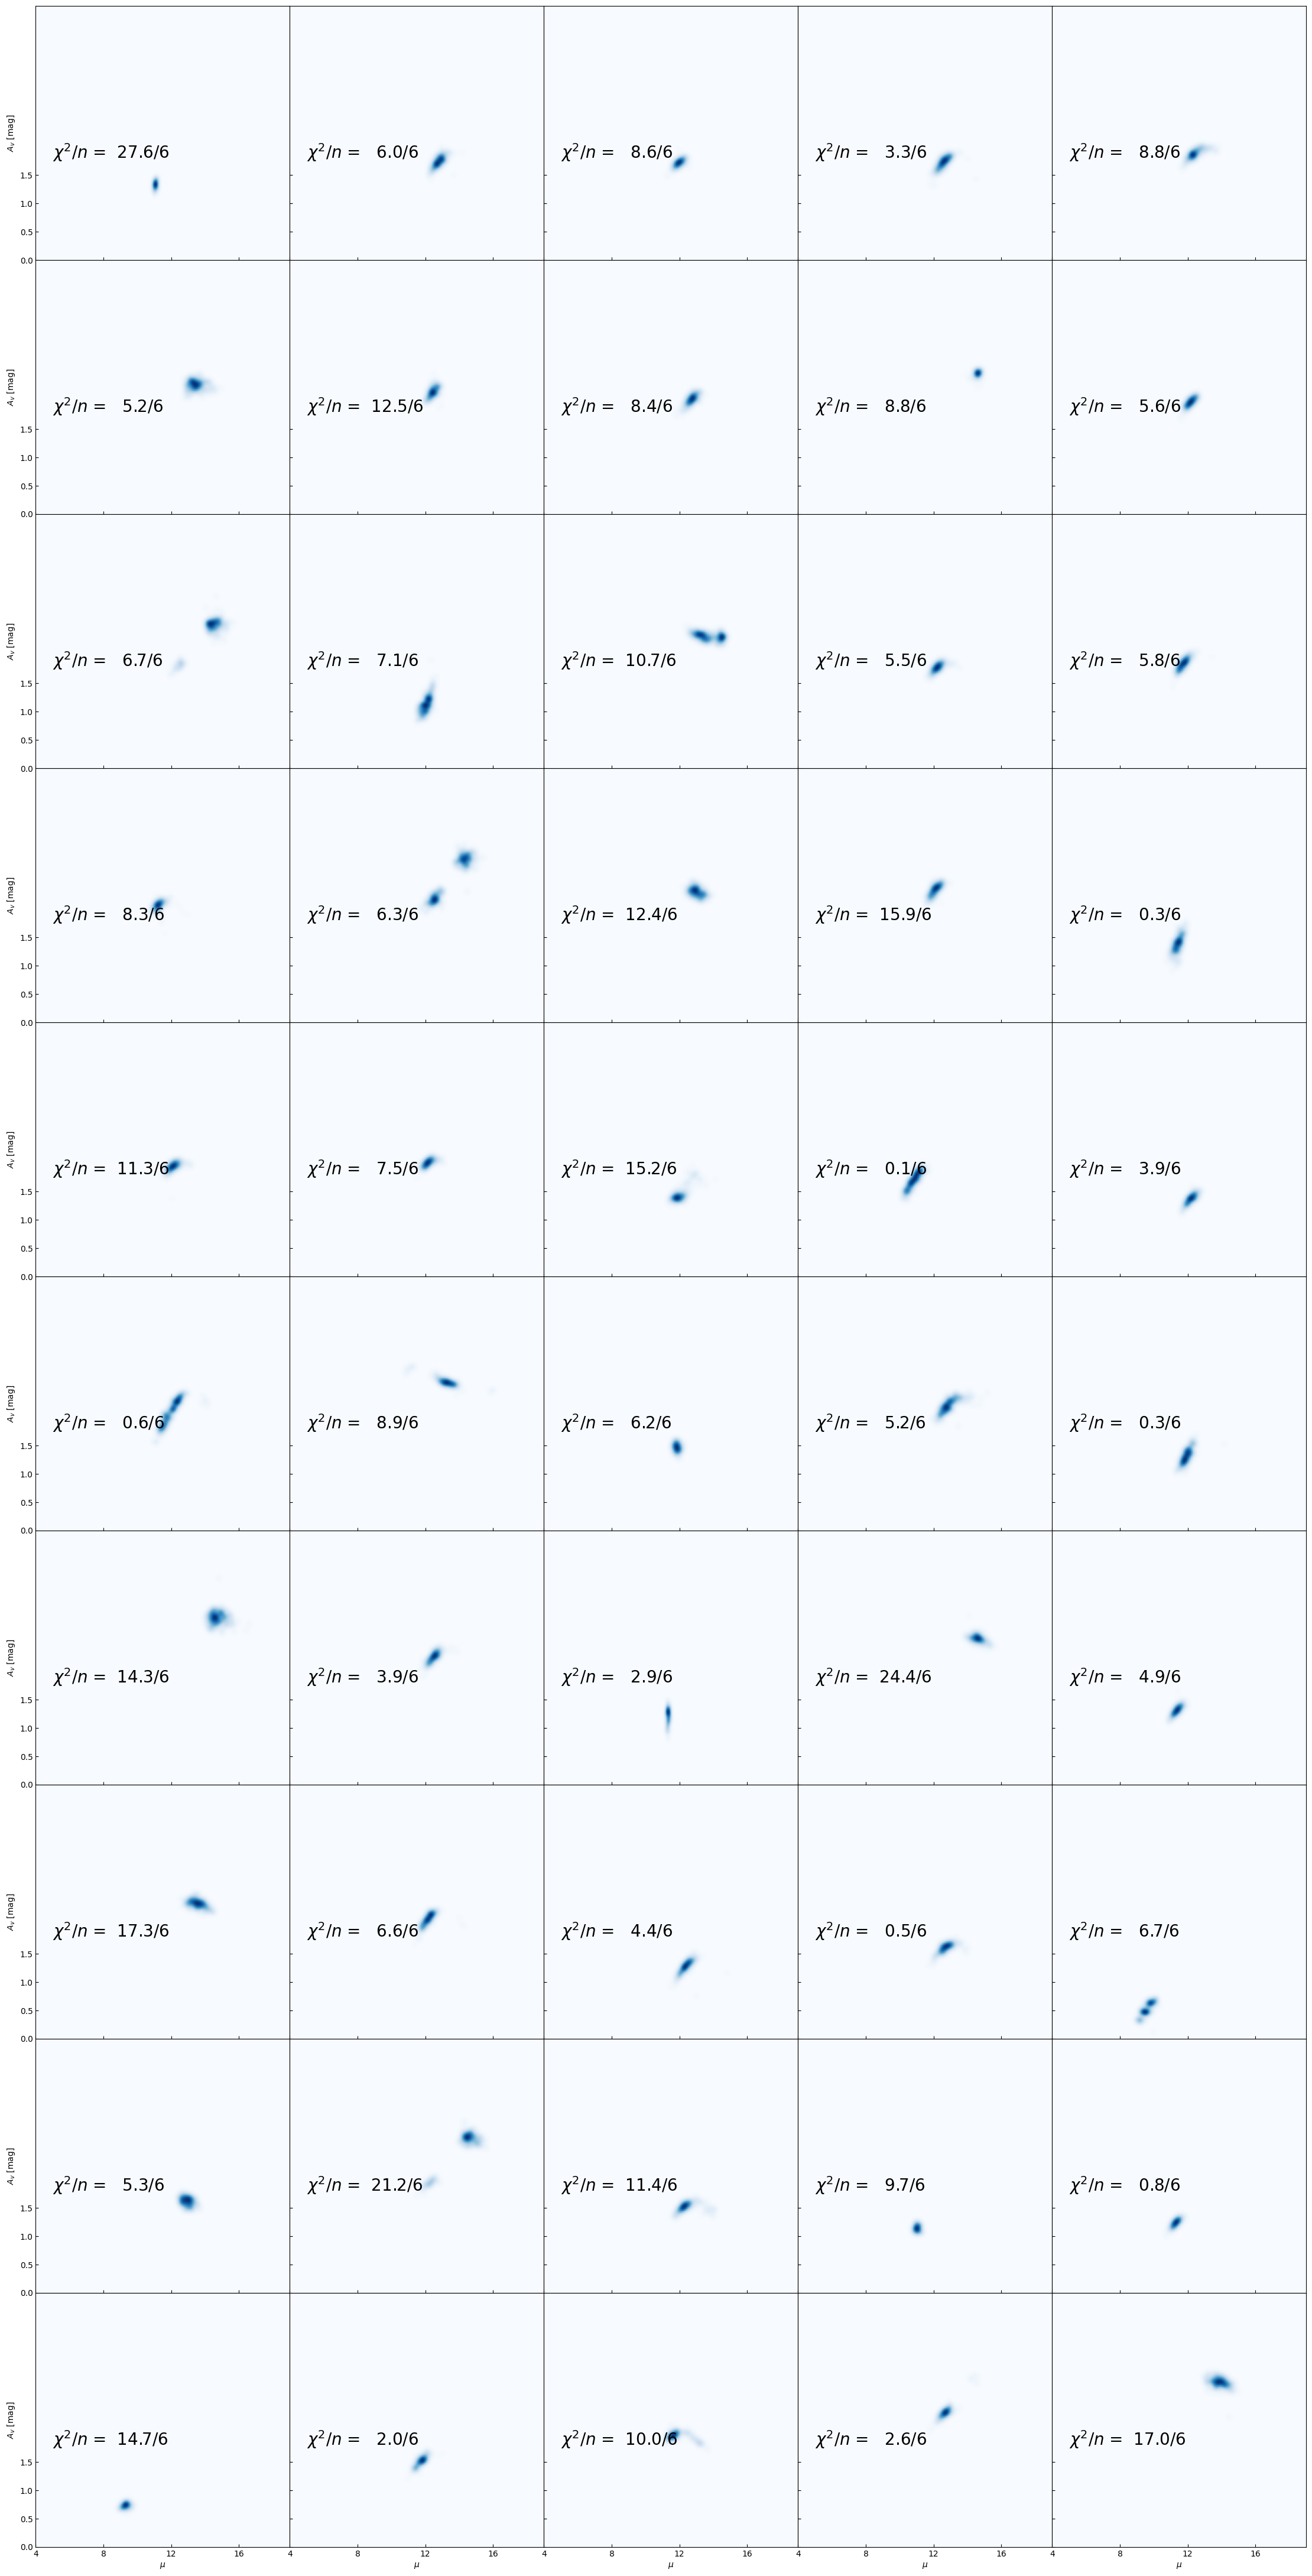

In [51]:
xdim, ydim = 25, 50

# distance-extinction 2-D posteriors
fig = plt.figure(figsize=(xdim, ydim))
fig.subplots_adjust(bottom=0.12, top=0.98,
                    left=0.12, right=0.98,
                    wspace=0.00, hspace=0.00) # adjust the spacing between subplots
for i in range(xdim//5 * ydim//5):
    plt.subplot(ydim//5, xdim//5, i+1)
    bplot.dist_vs_red((dists_mist[i], reds_mist[i], dreds_mist[i]), 
                      parallax=parallax[i],  # limits smoothing
                      parallax_err=parallax_err[i],  # if parallax SNR is high
                      avlim=(0., 4.5),
                      cmap='Blues')
    plt.tick_params(direction='in')
    if i % 5 == 0 and i >= xdim//5 * ydim//5 - 5:
        plt.xticks(np.arange(4., 19., 4.))
        plt.yticks(np.arange(0., 2., 0.5))
    elif i % 5 == 0:
        plt.xlabel('')
        plt.xticks(np.arange(4., 19., 4.), [])
        plt.yticks(np.arange(0., 2., 0.5))
    elif i >= xdim//5 * ydim//5 - 5:
        plt.ylabel('')
        plt.xticks(np.arange(4., 19., 4.))
        plt.yticks(np.arange(0., 2., 0.5), [])
    else:
        plt.xlabel('')
        plt.ylabel('')
        plt.xticks(np.arange(4., 19., 4.), [])
        plt.yticks(np.arange(0., 2., 0.5), [])
    plt.text(5., 1.8, r'$\chi^2/n$ ={:6.1f}/{:d}'
             .format(chi2_mist[i], nbands_mist[i]),
             fontsize=20)
    


# counts1 = bplot.dist_vs_red((dists_mist[i], reds_mist[i], dreds_mist[i]), 
#                                             parallax=parallax[i],  # limits smoothing
#                                             parallax_err=parallax_err[i],  # if parallax SNR is high
#                                             avlim=(0., 4.5),
#                                             cmap='Blues')
# plt.imshow(counts1[0].T, aspect='auto', cmap ='Blues',
#                      interpolation=None, origin='lower',
#                      extent=[counts1[1][0], counts1[1][-1], counts1[2][0], counts1[2][-1]],
#                      )

## Extinction Modeling

Use output stellar posterior samples to model the 3D distribuiton of dust via extinction

In [109]:
from __future__ import print_function, division
from six.moves import range
import sys
import numpy as np
import scipy
import matplotlib
from matplotlib import pyplot as plt
import h5py
import dynesty
from brutus import los
from brutus.los import LOS_clouds_priortransform as ptform
from brutus.los import LOS_clouds_loglike_samples as loglike


### Deriving Line-of-Sight Extinction Estimates

model the extinction estimates along a given line of sight (LOS) using functions defined in the 'los' module.

In [217]:
# convert from kpc to distance modulus
dms_mist = 5. * np.log10( dists_mist) + 10

In [234]:
nclouds = 1  # number of clouds
ndim = 2 * nclouds + 4  # number of parameters

# adjust default distance modulus limits in ptform
ptform_kwargs = {'dlims': (6., 10.)}

# distances and extinctions to be passed to loglike
logl_args = [dms_mist, reds_mist]
logl_kwargs = {'monotonic': True}  # extinctions must increase

# fit dust along the LOS with dynesty
sampler = dynesty.NestedSampler(loglike, ptform, ndim,
                                ptform_kwargs=ptform_kwargs,
                                logl_args=logl_args,
                                # logl_kwargs=logl_kwargs
                                )

In [235]:
sampler.run_nested(dlogz=0.01)


3165it [02:08,  1.98it/s, bound: 43 | nc: 141 | ncall: 50347 | eff(%):  6.286 | loglstar:   -inf < -3198.575 <    inf | logz: -3209.709 +/-  0.144 | dlogz: 380.548 >  0.010] /Users/anniegao/anaconda3/envs/ism/lib/python3.9/site-packages/dynesty/bounding.py:617: UserWarning: The enlargement factor for the ellipsoidal bounds determined from bootstrapping is very large. If you are using uniform sampling that may mean that the sampling will be inefficient. This may be caused by a very complex posterior shape. You may consider using more livepoints or different sampler (i.e. rslice or rwalk) or alternatively disable bootstrap (bootstrap=0)
  warnings.warn(
3183it [02:14,  4.85it/s, bound: 46 | nc: 34 | ncall: 52440 | eff(%):  6.070 | loglstar:   -inf < -3193.109 <    inf | logz: -3204.361 +/-  0.145 | dlogz: 375.186 >  0.010] /Users/anniegao/anaconda3/envs/ism/lib/python3.9/site-packages/dynesty/bounding.py:617: UserWarning: The enlargement factor for the ellipsoidal bounds determined from 

In [236]:
# save results
res = sampler.results

In [238]:
help(dyplot)

Help on module dynesty.plotting in dynesty:

NAME
    dynesty.plotting

DESCRIPTION
    A set of built-in plotting functions to help visualize ``dynesty`` nested
    sampling :class:`~dynesty.results.Results`.

FUNCTIONS
    _hist2d(x, y, smooth=0.02, span=None, weights=None, levels=None, ax=None, color='gray', plot_datapoints=False, plot_density=True, plot_contours=True, no_fill_contours=False, fill_contours=True, contour_kwargs=None, contourf_kwargs=None, data_kwargs=None)
        Internal function called by :meth:`cornerplot` used to generate a
        a 2-D histogram/contour of samples.
        
        Parameters
        ----------
        x : interable with shape (nsamps,)
           Sample positions in the first dimension.
        
        y : iterable with shape (nsamps,)
           Sample positions in the second dimension.
        
        span : iterable with shape (ndim,), optional
            A list where each element is either a length-2 tuple containing
            lower 

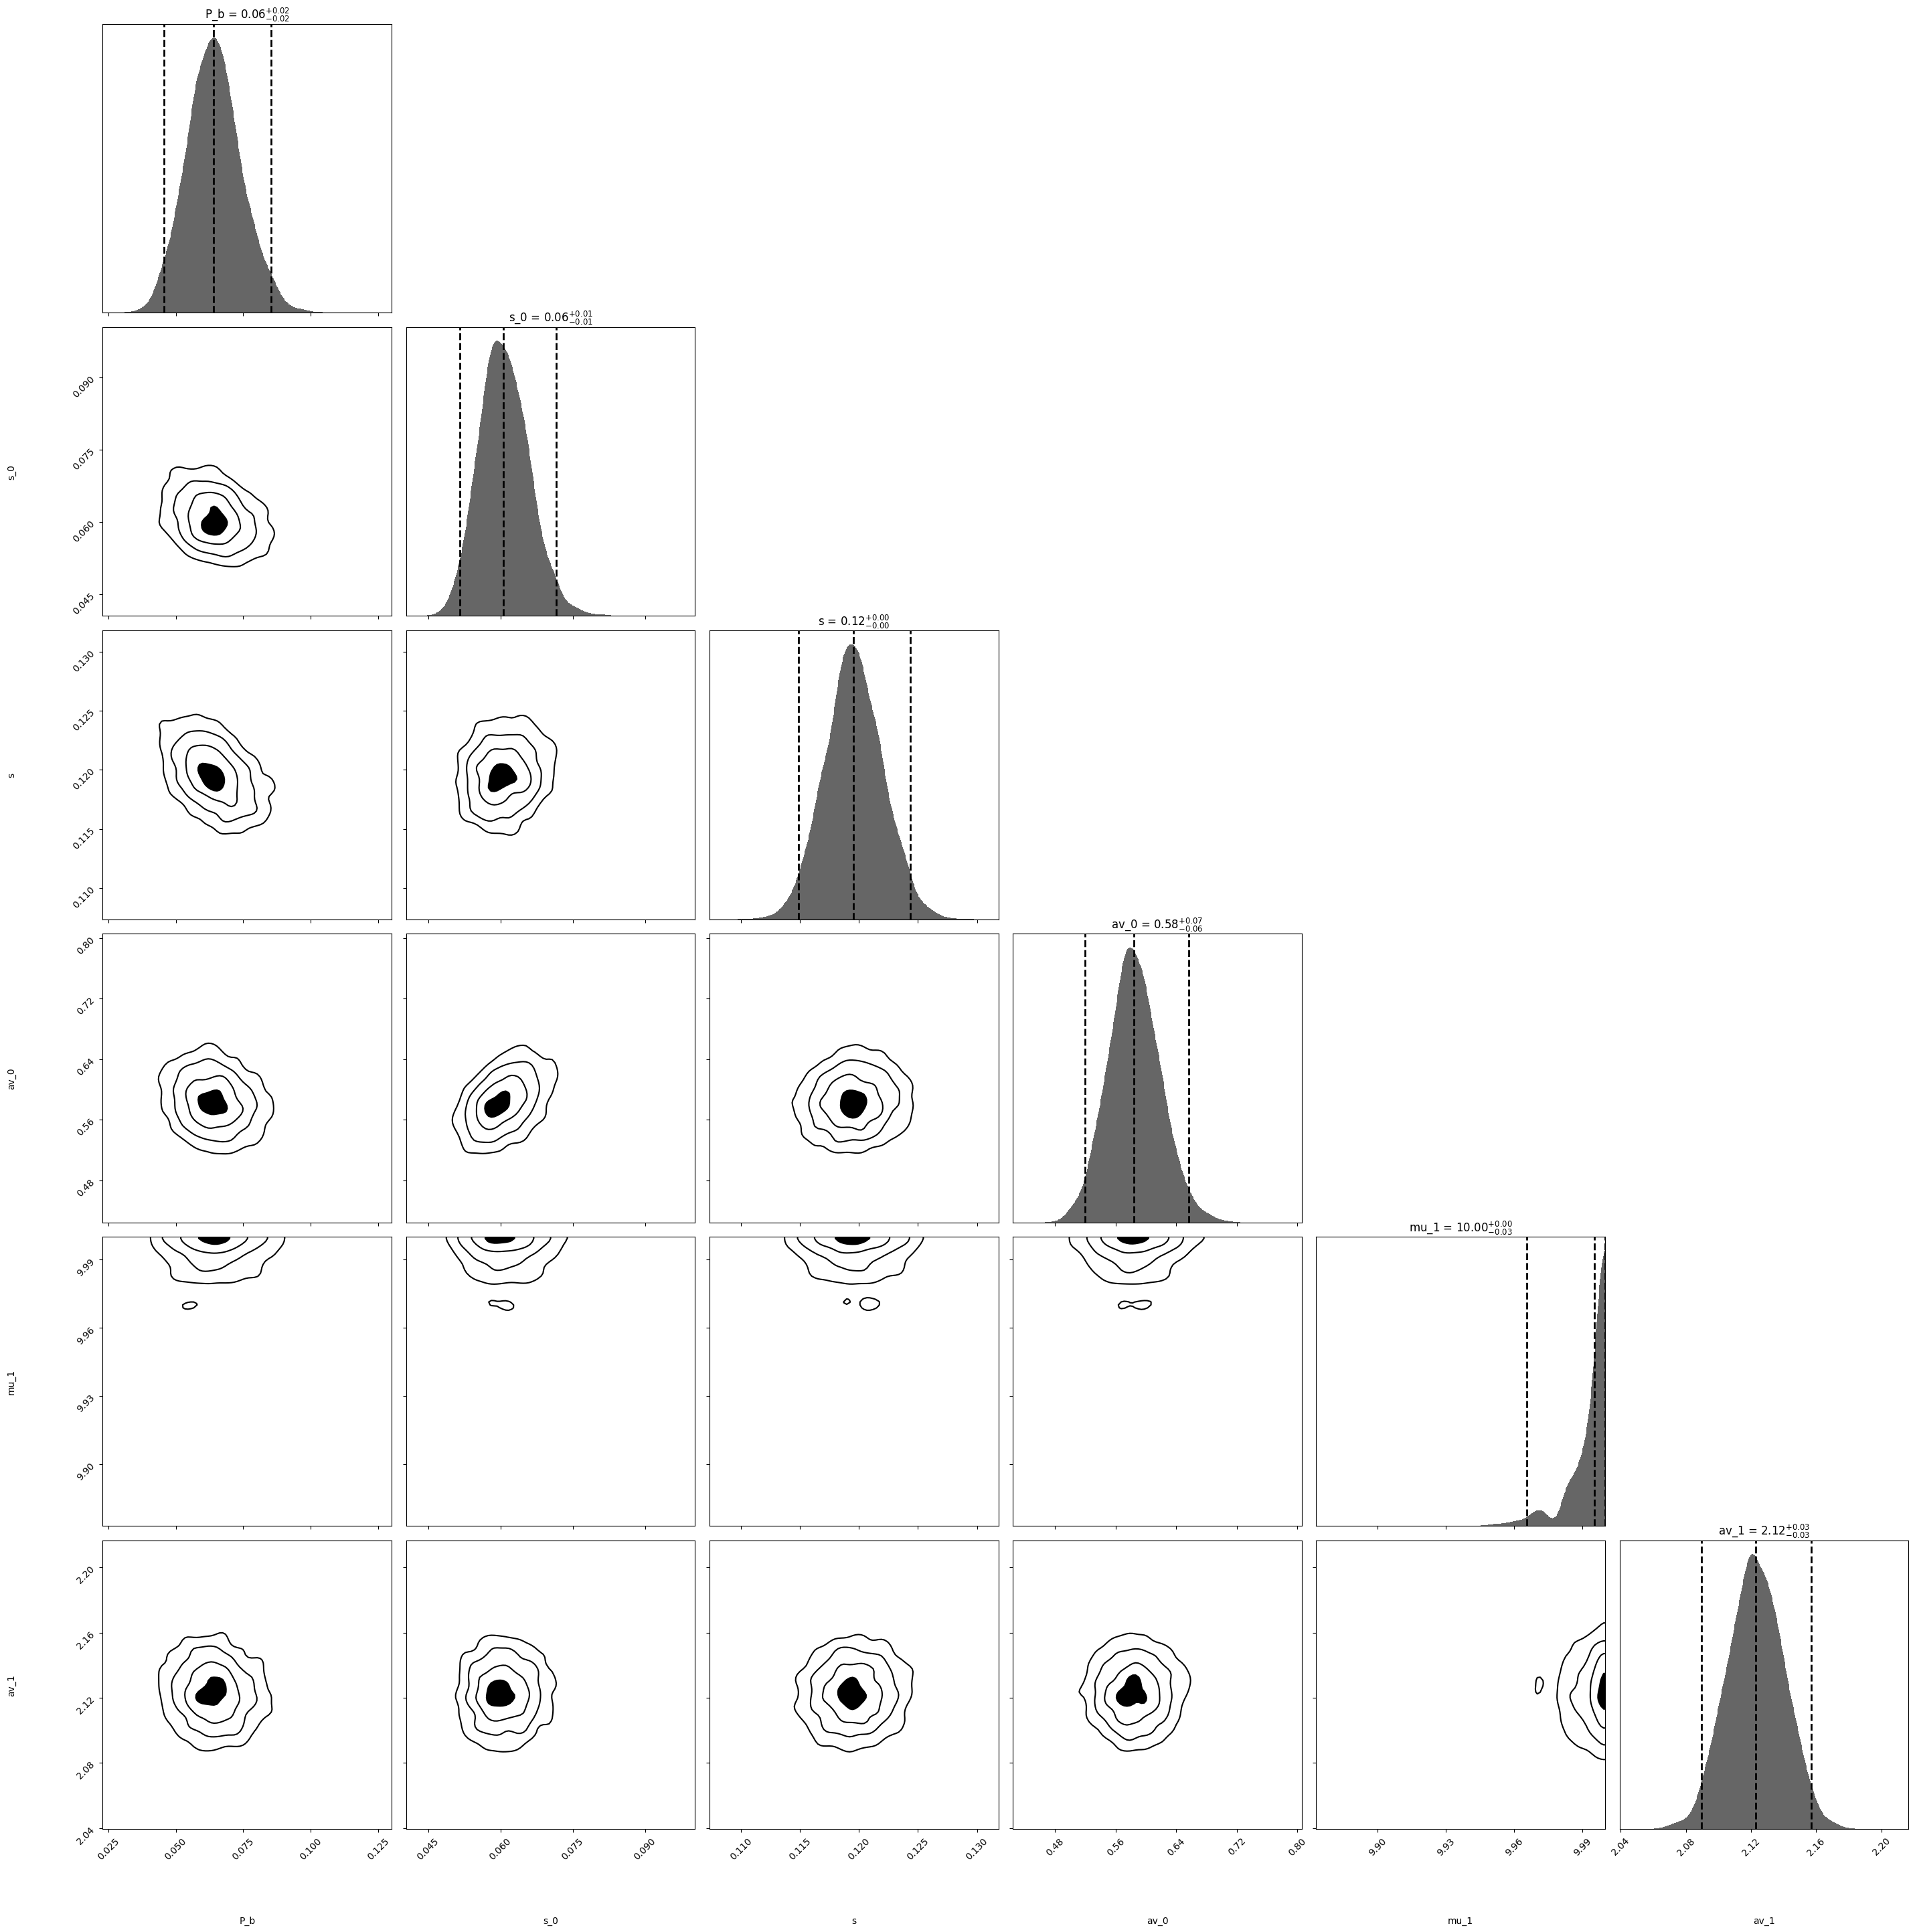

In [237]:
# plot results
from dynesty import plotting as dyplot

fig, ax = dyplot.cornerplot(res, 
                            labels=['P_b', 's_0', 's', 'av_0', 'mu_1', 'av_1'],
                            show_titles=True,
                            fig=plt.subplots(6, 6, figsize=(30, 30)))

## Double check the magnitude

In [351]:
# load in data
import brutus.utils


filename0 = 'Orion_l204.7_b-19.2'
f0 = h5py.File('/Users/anniegao/Downloads/Orion_l204.7_b-19.2.h5', 'r')
fpix0 = f0['photometry']['pixel 0-0']
mag0, magerr0 = fpix0['mag'], fpix0['err']
mask0 = np.isfinite(magerr0)  # create boolean band mask
phot0, err0 = brutus.utils.inv_magnitude(mag0, magerr0)  # convert to flux (in maggies)
objid0 = fpix0['obj_id']  # grab object id
parallax0, parallax_err0 = fpix0['parallax'] * 1e3, fpix0['parallax_error'] * 1e3  # convert to mas
psel0 = np.isclose(parallax_err0, 0.) | np.isclose(parallax0, 0.) | (parallax_err0 > 1e6)
parallax0[psel0], parallax_err0[psel0] = np.nan, np.nan
coords0 = np.c_[fpix0['l'], fpix0['b']]

Nobjs0 = len(phot0)
print(Nobjs0)

1642


/Users/anniegao/anaconda3/envs/ism/lib/python3.9/site-packages/brutus/utils.py:791: RuntimeWarning: overflow encountered in power
  phot = 10**(-0.4 * mag) * zeropoints


In [372]:
phot0[np.isfinite(phot0)].shape, flux_new.shape, 

((8846,), (2282, 5), (16127, 5))

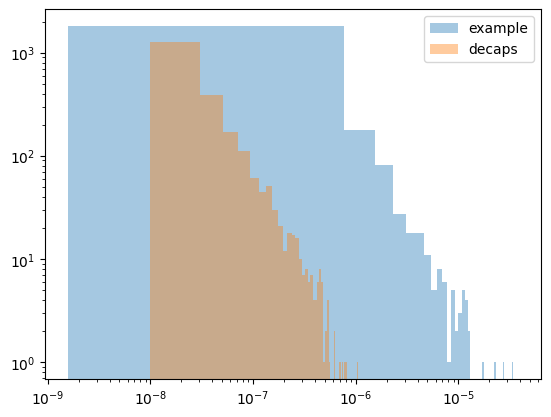

In [370]:
plt.hist(phot0[np.isfinite(phot0)][:2200], bins=50, alpha=0.4, label='example')
plt.hist(flux_new[:,0], bins=50, alpha= 0.4, label='decaps')
plt.loglog()
plt.legend()
plt.show()